Данные представляют собой 128 аудиофайлов человеческих голосов с 4 основными эмоциями: гнев, грусть, радость, страх.

Аудио может быть рассмотрено как мультивариативный временной ряд, особенно если рассматривать его с точки зрения аудиофункциональных признаков или спектральных представлений.

Каждая компонента ряда представляет собой амплитуду звука в определенный момент времени.

In [74]:
import pandas as pd
import matplotlib.pyplot  as plt
import os
import librosa
import numpy as np
import scipy
import keras
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
import torch.nn.functional as F
import torch.nn.init as init
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq, irfft
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc

my_seed = 42
torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

В данном проекте ставится задача 4-классовой классификации аудио по эмоциям на основе аудиофункциональных и спектральных характеристик.

### Метки классов

гнев - 0

грусть - 1

радость - 2

страх - 3

### Загрузка данных

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
dir = "/content/drive/MyDrive/"

In [77]:
dirname_anger = os.path.join(dir, 'data', 'гнев')
audio_anger = [os.path.join(dirname_anger, file) for file in os.listdir(dirname_anger) if file.endswith('.wav')]

dirname_sad = os.path.join(dir, 'data', 'грусть')
audio_sad = [os.path.join(dirname_sad, file) for file in os.listdir(dirname_sad) if file.endswith('.wav')]

dirname_happy = os.path.join(dir, 'data', 'радость')
audio_happy = [os.path.join(dirname_happy, file) for file in os.listdir(dirname_happy) if file.endswith('.wav')]

dirname_fear = os.path.join(dir, 'data', 'страх')
audio_fear = [os.path.join(dirname_fear, file) for file in os.listdir(dirname_fear) if file.endswith('.wav')]

Определим количество каналов для каждого аудио.

In [ ]:
print("Количество канало для каждого аудио класса 0")
for audio_file in audio_anger:
  audio, sr = librosa.load(audio_file, sr=None, mono=False)
  num_channels = audio.shape[0]
  print(f"Количество каналов: {num_channels}")

Количество канало для каждого аудио класса 0
Количество каналов: 294588
Количество каналов: 245637
Количество каналов: 71442
Количество каналов: 2
Количество каналов: 228438
Количество каналов: 255339
Количество каналов: 163170
Количество каналов: 129698
Количество каналов: 70427
Количество каналов: 213003
Количество каналов: 2
Количество каналов: 110646
Количество каналов: 273420
Количество каналов: 2
Количество каналов: 286209
Количество каналов: 278271
Количество каналов: 191394
Количество каналов: 2
Количество каналов: 2
Количество каналов: 203301
Количество каналов: 325899
Количество каналов: 85995
Количество каналов: 211680
Количество каналов: 102179
Количество каналов: 2
Количество каналов: 144648
Количество каналов: 230643
Количество каналов: 123347
Количество каналов: 138915
Количество каналов: 258426
Количество каналов: 2
Количество каналов: 78894


In [ ]:
print("Количество канало для каждого аудио класса 1")
for audio_file in audio_sad:
  audio, sr = librosa.load(audio_file, sr=None, mono=False)
  num_channels = audio.shape[0]
  print(f"Количество каналов: {num_channels}")

Количество канало для каждого аудио класса 1
Количество каналов: 2
Количество каналов: 132300
Количество каналов: 2
Количество каналов: 132300
Количество каналов: 482895
Количество каналов: 2
Количество каналов: 132300
Количество каналов: 105399
Количество каналов: 262836
Количество каналов: 287532
Количество каналов: 2
Количество каналов: 132300
Количество каналов: 231966
Количество каналов: 2
Количество каналов: 108927
Количество каналов: 423360
Количество каналов: 319725
Количество каналов: 151704
Количество каналов: 440559
Количество каналов: 281799
Количество каналов: 2
Количество каналов: 264159
Количество каналов: 228879
Количество каналов: 252252
Количество каналов: 213444
Количество каналов: 305172
Количество каналов: 132300
Количество каналов: 200655
Количество каналов: 79380
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2


In [ ]:
print("Количество канало для каждого аудио класса 2")
for audio_file in audio_happy:
  audio, sr = librosa.load(audio_file, sr=None, mono=False)
  num_channels = audio.shape[0]
  print(f"Количество каналов: {num_channels}")

Количество канало для каждого аудио класса 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 119070
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 215649
Количество каналов: 2
Количество каналов: 57330
Количество каналов: 66591
Количество каналов: 133623
Количество каналов: 175077
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 130536
Количество каналов: 52224
Количество каналов: 88641
Количество каналов: 2
Количество каналов: 80703
Количество каналов: 158319
Количество каналов: 97020
Количество каналов: 101430
Количество каналов: 2
Количество каналов: 132300
Количество каналов: 70119
Количество каналов: 2
Количество каналов: 2
Количество каналов: 90846
Количество каналов: 2
Количество каналов: 2


In [ ]:
print("Количество канало для каждого аудио класса 3")
for audio_file in audio_fear:
  audio, sr = librosa.load(audio_file, sr=None, mono=False)
  num_channels = audio.shape[0]
  print(f"Количество каналов: {num_channels}")

Количество канало для каждого аудио класса 3
Количество каналов: 130536
Количество каналов: 191394
Количество каналов: 83349
Количество каналов: 247842
Количество каналов: 50715
Количество каналов: 117306
Количество каналов: 79821
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 175518
Количество каналов: 2
Количество каналов: 90846
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 96579
Количество каналов: 45423
Количество каналов: 79821
Количество каналов: 175959
Количество каналов: 89523
Количество каналов: 2
Количество каналов: 205506
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 2
Количество каналов: 169344
Количество каналов: 166698


Для каждого аудиофайла количество каналов больше одного, это указывает на мультивариативный временной ряд. Каждый канал представляет собой отдельный временной ряд.

Визуализация рядов

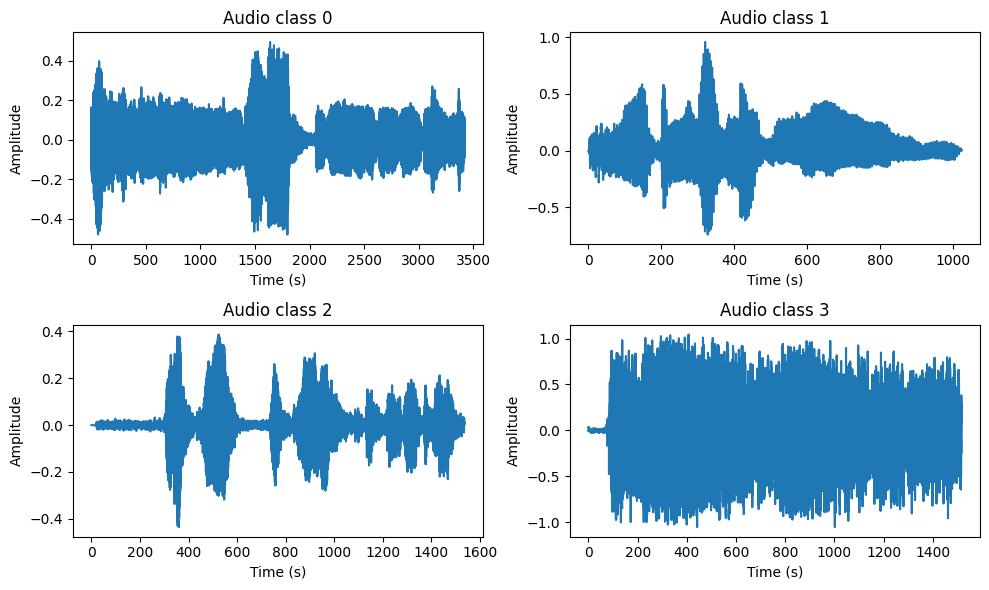

In [ ]:
import librosa
import matplotlib.pyplot as plt

audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, audio_file in enumerate(audio_files):
    audio, sr = librosa.load(audio_file)
    time = librosa.times_like(audio, sr=sr)

    row = i // 2
    col = i % 2

    axes[row, col].plot(time, audio)
    axes[row, col].set_xlabel('Time (s)')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].set_title(f'Audio class {i}')

plt.tight_layout()

plt.show()

### Анализ аудиофункциональных и спектральных характеристик.

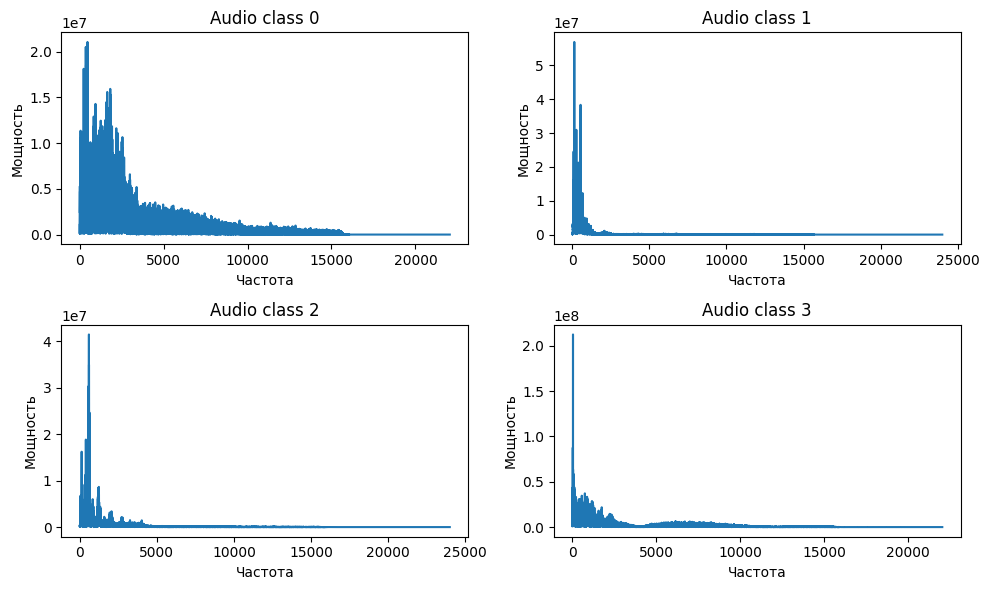

In [ ]:
audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for i, audio_file in enumerate(audio_files):
    samplerate, data = wavfile.read(audio_file)
    duration = len(data) / samplerate

    N = int(samplerate * duration)

    if data.ndim == 2:
        yf = rfft(data[:, 0])
    else:
        yf = rfft(data)
    xf = rfftfreq(N, 1 / samplerate)

    row = i // 2
    col = i % 2

    axes[row, col].plot(xf, np.abs(yf))
    axes[row, col].set_xlabel('Частота')
    axes[row, col].set_ylabel('Мощность')
    axes[row, col].set_title(f'Audio class {i}')

plt.tight_layout()
plt.show()

 По графикам видно, что в основном преобладают частоты ниже 5000 Гц для всех классов. Для класса 0 немного выделяются высокие частоты.

Мел-кепстральные коэффициенты (MFCC)

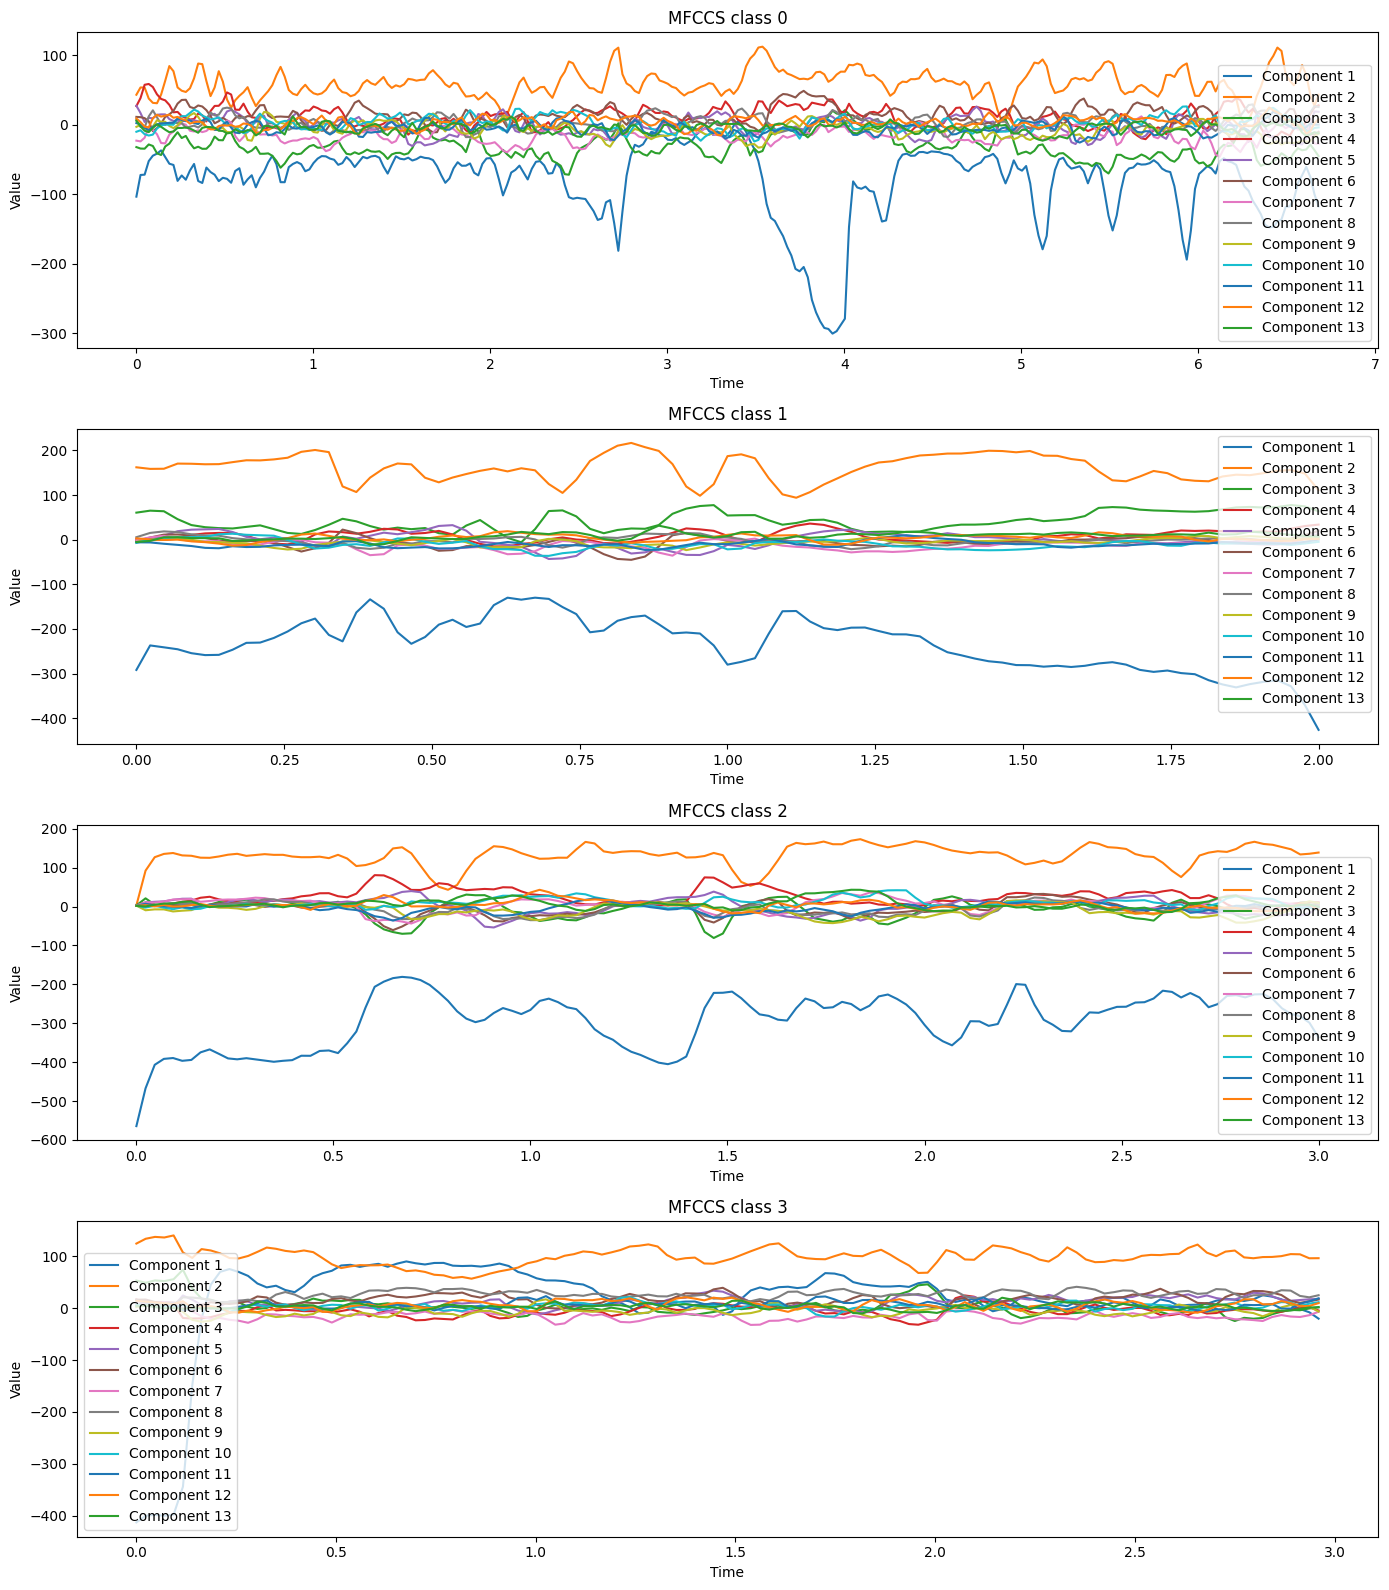

In [ ]:
audio_files = [audio_anger[0], audio_sad[0], audio_happy[0], audio_fear[0]]
features = []
durations = []
times = []

fig, axes = plt.subplots(4, 1, figsize=(14, 16))

for i, audio_file in enumerate(audio_files):
    audio, sr = librosa.load(audio_file)
    feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    duration = librosa.get_duration(y=audio, sr=sr)
    time = np.linspace(0, duration, num=feature.shape[1])

    features.append(feature)
    durations.append(duration)
    times.append(time)

    for j in range(feature.shape[0]):
        axes[i].plot(time, feature[j, :], label=f'Component {j+1}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'MFCCS class {i}')
    axes[i].legend()

plt.tight_layout()

plt.show()

По графикам видно, что амплитуда звука сильнее меняется во времени у злости и радости. Меньше всего меняется у страха.

### Предобработка ряда и извлечение свойств:

MFCC - коэффициенты, описывающие форму спектра звукового сигнала на основе мел-шкалы частот.

Спектральный центроид - представляет средневзвешенное значение частоты спектра звука и является мерой "центра масс" спектра.

Хроматические признаки - отражают степень преобладания различных музыкальных нот в аудиосигнале.

Спектральный контраст - это мера различия амплитуд между различными частотными полосами в спектре аудиосигнала.

Эти признаки могут отражать особенности речевого сигнала, такие как тембр, интонация, ритм и другие акустические характеристики звукового сигнала, которые могут быть полезными при классификации речи.


In [78]:
def extract_features(audio_path):
    audio, sr = librosa.load(audio_path)

    spectrogram = np.abs(librosa.stft(audio))
    magnitudes = np.mean(spectrogram, axis=1)

    threshold_low = np.percentile(magnitudes, 10)
    threshold_high = np.percentile(magnitudes, 90)

    low_pass_filter = scipy.signal.firwin(101, threshold_low, fs=sr, pass_zero=False)
    audio_low_pass = scipy.signal.lfilter(low_pass_filter, 1, audio)

    high_pass_filter = scipy.signal.firwin(101, threshold_high, fs=sr, pass_zero=True)
    audio_high_pass = scipy.signal.lfilter(high_pass_filter, 1, audio)

    audio_filtered = audio_low_pass + audio_high_pass

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    spectral_center = librosa.feature.spectral_centroid(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

    mfcc_mean = np.mean(mfcc, axis=1)
    spectral_center_mean = np.mean(spectral_center, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    features = np.concatenate((mfcc_mean, spectral_center_mean, chroma_mean, spectral_contrast_mean))

    return features

In [113]:
features = []
labels = []

for file in audio_anger:
    audio_features = extract_features(file)
    features.append(audio_features)
    labels.append(0)

for file in audio_sad:
    audio_features = extract_features(file)
    features.append(audio_features)
    labels.append(1)

for file in audio_happy:
    audio_features = extract_features(file)
    features.append(audio_features)
    labels.append(2)

for file in audio_fear:
    audio_features = extract_features(file)
    features.append(audio_features)
    labels.append(3)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.15, random_state=42)

### Модель 1.

Классический алгоритм - случайный лес.

Подбираем параметры с помощью Random Search

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


param_grid = {
    'n_estimators': [200, 250, 300, 350, 400],
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

classifier = RandomForestClassifier()

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, cv=5)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

best_classifier = RandomForestClassifier(random_state=my_seed, **best_params)
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_proba = best_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Roc_auc:", roc_auc)

precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1)

Accuracy: 0.8
Roc_auc: 0.9584226190476192
Precision: 0.8083333333333333
Recall: 0.7958333333333334
F1 score: 0.7972222222222223


Доля правильных ответов, в целом, неплохая, но не отлично.

Roc_auc - хорошо

Precision, Recall, F1 - нормально

In [80]:
def view_metric(y_test, y_pred, y_pred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(15, 6))

    # ROC curve
    plt.subplot(1, 2, 1)
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

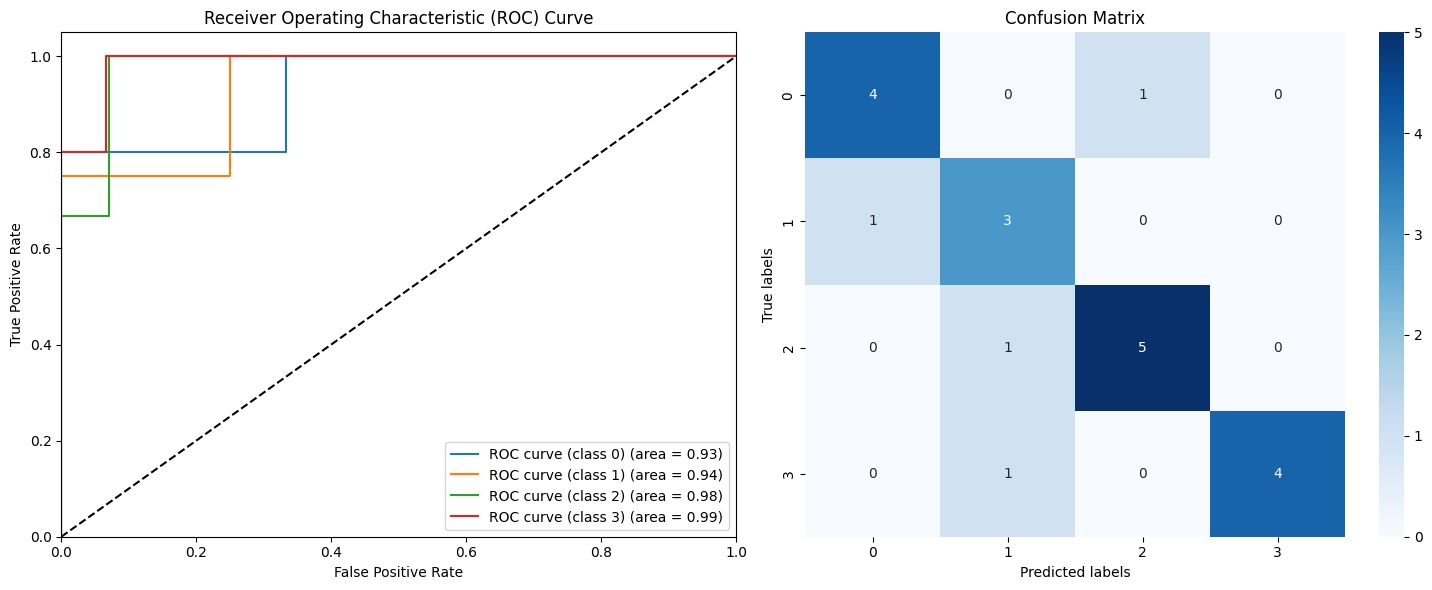

In [114]:
view_metric(y_test, y_pred, y_pred_proba)

По графику видно, что нормально предсказываются классы 1-3. Хуже всего предсказывается гнев.

### Модель 2.

Классический алгоритм - градиентный бустинг.

Подбираем параметры с помощью Random Search

In [116]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

classifier = GradientBoostingClassifier()

random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=10, cv=5)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

best_classifier = GradientBoostingClassifier(random_state=my_seed, **best_params)
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_proba = best_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Roc_auc:", roc_auc)

precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1)

Accuracy: 0.7
Roc_auc: 0.921063988095238
Precision: 0.7291666666666666
Recall: 0.7041666666666666
F1 score: 0.7055555555555555


Accuracy - плохо.

Roc_auc - нормально

Precision, Recall, F1 - нормально

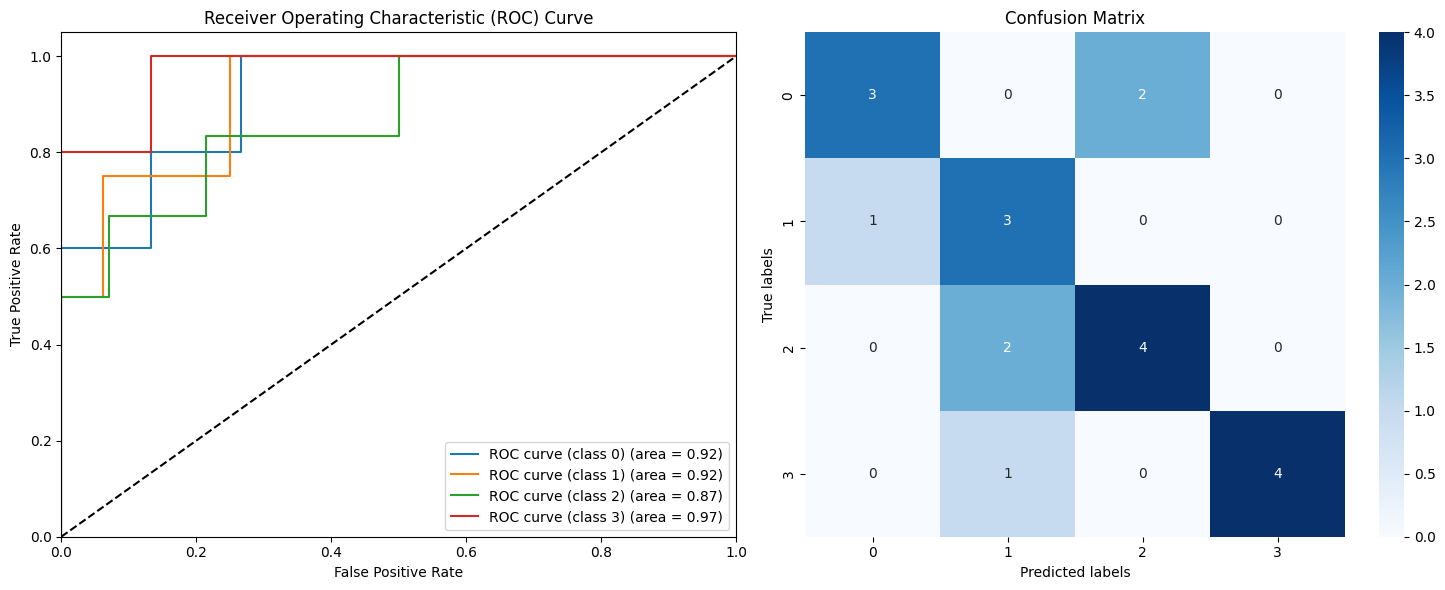

In [117]:
view_metric(y_test, y_pred, y_pred_proba)

По графику видно, что хорошо предсказывается класс 3. Злость и радость предсказываются хуже.

### Подготовка данных для нейросетей.

In [118]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 8
train_dataset = torch_data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch_data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Модель 3.

Нейросеть LSTM c 2 lstm слоями и 1 линейным.

На выходе - логарифм функции softmax от линейного преобразования.

Функция потерь - Negative Log Likelihood Loss для log_softmax.

Оптимизатор - Adam.

В ходе экспериментов log_softmax на выходе работает лучше, чем softmax.


In [98]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.hidden_size = 128
        self.num_layers = 2
        self.lstm = nn.LSTM(1, 128, 2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.view(batch_size, seq_len, -1)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = F.log_softmax(out, dim=1)
        return out


In [99]:
from sklearn.metrics import accuracy_score, roc_auc_score

def train_model(model, loader, loss_fn, optimizer, n_epochs):
    model.train()

    train_losses = []
    test_losses = []

    for epoch in range(1, n_epochs + 1):
        for X_batch, y_batch in loader:
            X_batch = X_batch.float()
            y_batch = y_batch.long()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 1 == 0:
          model.eval()
          with torch.no_grad():
                y_pred_train = model(X_train_tensor)
                predicted_classes_train = torch.argmax(y_pred_train, axis=1)
                train_acc = accuracy_score(predicted_classes_train.cpu().numpy(), y_train_tensor.cpu().numpy())

                y_pred_test = model(X_test_tensor)
                predicted_classes_test = torch.argmax(y_pred_test, axis=1)
                test_acc = accuracy_score(predicted_classes_test.cpu().numpy(), y_test_tensor.cpu().numpy())

                print("Epoch %d: train accuracy %.4f, test accuracy %.4f" % (epoch, train_acc, test_acc))

                y_prob_train = F.softmax(y_pred_train, dim=1).cpu().numpy()
                y_prob_test = F.softmax(y_pred_test, dim=1).cpu().numpy()

                roc_auc_train = roc_auc_score(y_train_tensor.cpu().numpy(), y_prob_train, multi_class='ovr')
                roc_auc_test = roc_auc_score(y_test_tensor.cpu().numpy(), y_prob_test, multi_class='ovr')

                print("Epoch %d: train ROC AUC %.4f, test ROC AUC %.4f" % (epoch, roc_auc_train, roc_auc_test))

In [119]:
loss_fn = nn.NLLLoss()
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [120]:
n_epochs = 100
train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.2593, test accuracy 0.2000
Epoch 1: train ROC AUC 0.7042, test ROC AUC 0.8379
Epoch 2: train accuracy 0.2500, test accuracy 0.2500
Epoch 2: train ROC AUC 0.6824, test ROC AUC 0.8729
Epoch 3: train accuracy 0.3704, test accuracy 0.4000
Epoch 3: train ROC AUC 0.6795, test ROC AUC 0.8540
Epoch 4: train accuracy 0.3519, test accuracy 0.5000
Epoch 4: train ROC AUC 0.6802, test ROC AUC 0.8240
Epoch 5: train accuracy 0.2593, test accuracy 0.2000
Epoch 5: train ROC AUC 0.6866, test ROC AUC 0.8340
Epoch 6: train accuracy 0.3704, test accuracy 0.4000
Epoch 6: train ROC AUC 0.6748, test ROC AUC 0.7440
Epoch 7: train accuracy 0.3241, test accuracy 0.4000
Epoch 7: train ROC AUC 0.6777, test ROC AUC 0.7201
Epoch 8: train accuracy 0.3611, test accuracy 0.4500
Epoch 8: train ROC AUC 0.7038, test ROC AUC 0.8034
Epoch 9: train accuracy 0.4444, test accuracy 0.6000
Epoch 9: train ROC AUC 0.7189, test ROC AUC 0.8908
Epoch 10: train accuracy 0.3148, test accuracy 0.3500
Epoch 10: 

Нейросеть в функции train_model обучается на тренировочном лодере. Но качество предсказаний отслеживается на тренировочном и на тестовом, чтобы понять обобщающую способность модели.

In [121]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import torch

def calculate_accuracy(y_pred, y_true):
    accuracy = accuracy_score(y_pred, y_true)
    return accuracy

def calculate_roc_auc(y_pred_prob, y_true):
    roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    return roc_auc

def calculate_precision(y_pred, y_true):
    precision = precision_score(y_true, y_pred, average='weighted')
    return precision

def calculate_recall(y_pred, y_true):
    recall = recall_score(y_true, y_pred, average='weighted')
    return recall

def calculate_f1_score(y_pred, y_true):
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1

def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    y_pred_prob = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())
            y_pred_prob.extend(torch.nn.functional.softmax(outputs, dim=1).tolist())

    return predictions, true_labels, y_pred_prob

In [124]:
def view_metric_nn(y_test, y_pred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(y_pred_proba[0])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, [pred[i] for pred in y_pred_proba], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(15, 6))

    # ROC curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Confusion Matrix
    plt.subplot(1, 2, 2)
    y_pred = np.argmax(y_pred_proba, axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [123]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("LSTM")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


LSTM
Accuracy: 0.75
ROC AUC: 0.9441145833333333
Precision: 0.7383333333333333
Recall: 0.75
F1 Score: 0.740909090909091


Accuracy - неплохо.

Roc_auc - в целом, нормально

Precision, Recall, F1 - неплохо

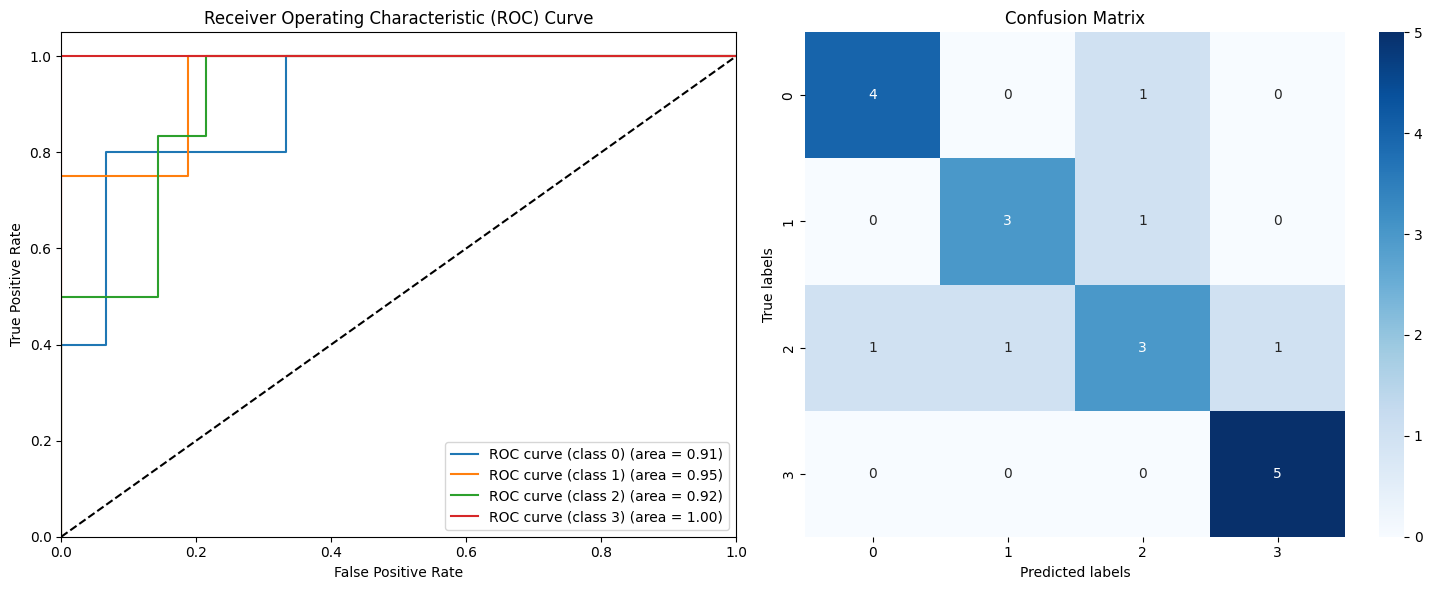

In [125]:
view_metric_nn(true_labels, y_pred_prob)

Отлично предсказывается страх. Хорошо - гнев и грусть. Плохо предсказывается радость.

### Модель 4.

Рекурентная нейронная сеть c 3 RNN слоями и 3 полносвязными.

На выходе - логарифм функции softmax от линейного преобразования.

Функция активации - ELU (лучше всего работает)

Функция потерь - Negative Log Likelihood Loss для log_softmax.

Оптимизатор - Adam.

В ходе экспериментов log_softmax на выходе работает лучше, чем softmax.


In [126]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.hidden_size = 128
        self.num_layers = 3
        self.rnn = nn.RNN(1, 128, 3, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, 4)
        self.elu = nn.ELU()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.view(batch_size, seq_len, -1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [127]:
loss_fn = nn.NLLLoss()
model = RNN()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [128]:
n_epochs = 100
train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.2500, test accuracy 0.2500
Epoch 1: train ROC AUC 0.6648, test ROC AUC 0.6787
Epoch 2: train accuracy 0.2593, test accuracy 0.2000
Epoch 2: train ROC AUC 0.6763, test ROC AUC 0.7599
Epoch 3: train accuracy 0.2500, test accuracy 0.2500
Epoch 3: train ROC AUC 0.6409, test ROC AUC 0.5531
Epoch 4: train accuracy 0.2407, test accuracy 0.3000
Epoch 4: train ROC AUC 0.6869, test ROC AUC 0.6026
Epoch 5: train accuracy 0.3148, test accuracy 0.4000
Epoch 5: train ROC AUC 0.7440, test ROC AUC 0.7013
Epoch 6: train accuracy 0.4167, test accuracy 0.7000
Epoch 6: train ROC AUC 0.7058, test ROC AUC 0.7851
Epoch 7: train accuracy 0.4630, test accuracy 0.6500
Epoch 7: train ROC AUC 0.7227, test ROC AUC 0.8451
Epoch 8: train accuracy 0.4352, test accuracy 0.4000
Epoch 8: train ROC AUC 0.7137, test ROC AUC 0.7583
Epoch 9: train accuracy 0.4537, test accuracy 0.5500
Epoch 9: train ROC AUC 0.7478, test ROC AUC 0.7472
Epoch 10: train accuracy 0.3981, test accuracy 0.3500
Epoch 10: 

In [129]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("RNN")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

RNN
Accuracy: 0.7
ROC AUC: 0.9113541666666668
Precision: 0.73125
Recall: 0.7
F1 Score: 0.6934188034188035


Accuracy - не очень хорошо.

Roc_auc - в целом, нормально

Precision, Recall, F1 - неплохо

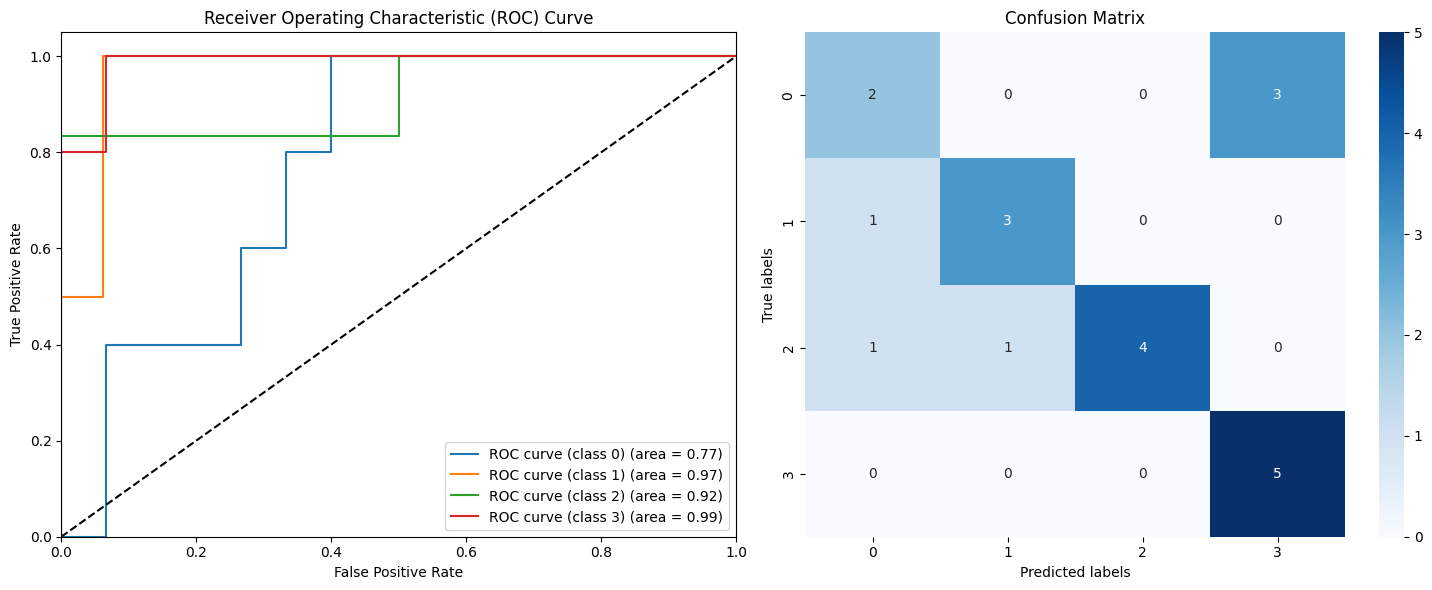

In [130]:
view_metric_nn(true_labels, y_pred_prob)

Отлично предсказывается страх. Хорошо - грусть. Нормально - радость. Плохо предсказывается гнев.

### Модель 5.

Сверточная нейронная сеть c 4 сверточными слоями и 1 линейным.

Функция активации - ReLU (лучше всего работает)

Функция потерь - CrossEntropyLoss.

Оптимизатор - AdamW.

In [131]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []
        self.conv1 = nn.Conv2d(33, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=4)

        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = x.view(batch_size, seq_len, -1)
        x = x.unsqueeze(1)
        x = x.view(batch_size, seq_len, 1, -1)
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        return x

In [134]:
loss_fn = nn.CrossEntropyLoss()
model = CNN()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [135]:
n_epochs = 100
train_model(model, train_dataloader, loss_fn, optimizer, n_epochs)

Epoch 1: train accuracy 0.2407, test accuracy 0.1500
Epoch 1: train ROC AUC 0.6298, test ROC AUC 0.6406
Epoch 2: train accuracy 0.3148, test accuracy 0.4000
Epoch 2: train ROC AUC 0.6776, test ROC AUC 0.7324
Epoch 3: train accuracy 0.4167, test accuracy 0.4500
Epoch 3: train ROC AUC 0.7250, test ROC AUC 0.6561
Epoch 4: train accuracy 0.4907, test accuracy 0.4500
Epoch 4: train ROC AUC 0.7248, test ROC AUC 0.5949
Epoch 5: train accuracy 0.4259, test accuracy 0.3500
Epoch 5: train ROC AUC 0.7512, test ROC AUC 0.7508
Epoch 6: train accuracy 0.4537, test accuracy 0.5000
Epoch 6: train ROC AUC 0.7908, test ROC AUC 0.7743
Epoch 7: train accuracy 0.4722, test accuracy 0.4500
Epoch 7: train ROC AUC 0.7854, test ROC AUC 0.7732
Epoch 8: train accuracy 0.4630, test accuracy 0.3000
Epoch 8: train ROC AUC 0.7699, test ROC AUC 0.7309
Epoch 9: train accuracy 0.4722, test accuracy 0.4500
Epoch 9: train ROC AUC 0.7988, test ROC AUC 0.8096
Epoch 10: train accuracy 0.5556, test accuracy 0.5500
Epoch 10: 

In [136]:
test_predictions, true_labels, y_pred_prob = get_predictions(model, test_dataloader)

accuracy = calculate_accuracy(test_predictions, true_labels)
roc_auc = calculate_roc_auc(y_pred_prob, true_labels)
precision = calculate_precision(test_predictions, true_labels)
recall = calculate_recall(test_predictions, true_labels)
f1 = calculate_f1_score(test_predictions, true_labels)

print("CNN")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

CNN
Accuracy: 0.85
ROC AUC: 0.9855208333333334
Precision: 0.8583333333333332
Recall: 0.85
F1 Score: 0.8436507936507937


Accuracy - хорошо.

Roc_auc - отлично

Precision, Recall, F1 - хорошо

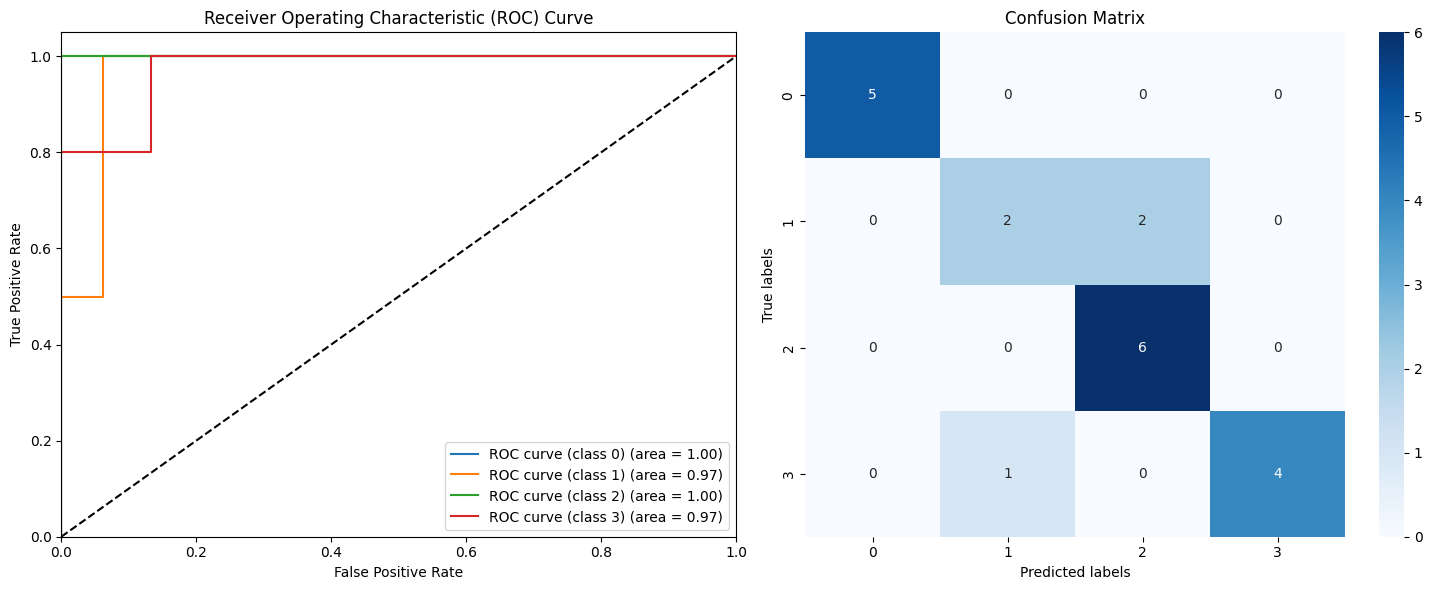

In [137]:
view_metric_nn(true_labels, y_pred_prob)

Отлично предсказывается гнев и радость. Неплохо - грусть и страх.

### Итог

Что получилось: получить неплохие результаты, извлечь нужные свойства для классификации аудио с речью, использовать и получить неплохие результаты с помощью различных видов нейросетей.<br>

Что не получилось: до конца пока не ясно, какие именно свойства и в какой мере влияют на качество моделей.

Для улучшения качества модели требуется намного больше данных, но удалось собрать только 128 объектов, что, конечно, мало для качественного обучения.
